In [33]:
import sys
sys.path.append('/Users/akash/personal/finance/market-regime/')


import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.neighbors import NearestNeighbors
from models.autoencoder import Autoencoder
from models.contrastive_transformer import ContrastiveTransformer
from utils.config_loader import load_config
from models.storage import save_model, load_model
from torch.utils.tensorboard import SummaryWriter
import os
import modin as mpd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import ks_2samp, entropy


In [22]:
import sys
import os

# Add the utils directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

import pandas as pd
import modin.pandas as mpd
from utils import clickhouse_data
import numpy as np
import talib
from sklearn.decomposition import PCA

# Define parameters
start_date = '2017-01-01'
end_date = '2025-12-31'

# Load and preprocess data
large_cap = clickhouse_data.clickhouse_largecap(start_date, end_date, size=1)
# mid_cap = clickhouse_data.clickhouse_midcap(start_date, end_date, size=1)
# small_cap = clickhouse_data.clickhouse_smallcap(start_date, end_date)

# # Fill missing dates
# large_cap = clickhouse_data.fill_missing_dates_modin_optimized(large_cap)
# mid_cap = clickhouse_data.fill_missing_dates_modin_optimized(mid_cap)
# small_cap = clickhouse_data.fill_missing_dates_modin_optimized(small_cap)

# Stack dataframes
all_cap = mpd.concat([large_cap])




    SELECT 
        financialinstrumentid,
        date,
        open,
        high,
        low,
        close,
        lastprice,
        previouscloseprice,
        volume,
        totaltradingvolume,
        totaltradevalue,
        totalnumberoftradesexecuted,
        tickersymbol,
        securityseries,
        settlementprice,
        financialinstrumentname
    FROM stock_data.tickers
    WHERE financialinstrumentid IN ('500002',) AND date BETWEEN '2017-01-01' AND '2025-12-31'
    ORDER BY financialinstrumentid, date ASC
    


In [38]:

import numpy as np
import pandas as pd
import talib
from prophet import Prophet

def extract_all_features(df):
    """
    Master function that:
    1. Retains raw OHLCV & additional trading data.
    2. Computes trend-based, volatility, liquidity, and microstructure features.
    3. Computes advanced technical indicators.
    4. Extracts seasonal components using Prophet.
    5. Ensures all feature columns are complete and normalized.
    """
    
    df = df.copy()

    # === Retain Raw Data for Reference ===
    raw_cols = [
        'date', 'open', 'high', 'low', 'close', 'lastprice', 'previouscloseprice',
        'volume', 'totaltradingvolume', 'totaltradevalue', 'totalnumberoftradesexecuted'
    ]
    df = df[raw_cols]  # Ensure we only work with the relevant columns

    # Ensure proper datetime format
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # === Compute Derived Features ===
    
    ## 🔹 Trend-Based Features
    df = clickhouse_data.compute_trend_features(df)

    ## 🔹 Volatility Features
    df = clickhouse_data.compute_volatility_features(df)

    ## 🔹 Liquidity Features (Includes Total Trading Volume & Trade Value)
    df = clickhouse_data.compute_liquidity_features(df)

    ## 🔹 Market Microstructure Features (VWAP, etc.)
    df = clickhouse_data.compute_microstructure_features(df)

    # === Derived Features from Additional Trading Data ===

    # 🔹 Previous Close Return (Gap Indicator)
    df['prev_close_return'] = np.log(df['close'] / df['previouscloseprice'])

    # 🔹 Trading Intensity (Total Trades / Volume)
    df['trading_intensity'] = df['totalnumberoftradesexecuted'] / df['totaltradingvolume']

    # 🔹 Turnover Ratio (Liquidity Proxy)
    df['turnover_ratio'] = df['totaltradevalue'] / df['totaltradingvolume']

    # 🔹 VWAP Ratio (Price Positioning)
    df['vwap_ratio'] = df['close'] / df['vwap']
    
    # 🔹 High-Low & Close-Open Ratios
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']

    # === Advanced Technical Indicators ===
    df['cci_20'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=20)
    df['williams_r'] = talib.WILLR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['stoch_k'], df['stoch_d'] = talib.STOCH(
        df['high'].values, df['low'].values, df['close'].values, 
        fastk_period=14, slowk_period=3, slowd_period=3
    )
    df['chande_momentum'] = talib.CMO(df['close'].values, timeperiod=14)
    df['ulcer_index'] = np.sqrt((df['close'].rolling(14).max().values - df['close'].values) ** 2 / 14)
    df['obv'] = talib.OBV(df['close'].astype(float).values, df['volume'].astype(float).values)
    df['chaikin_money_flow'] = talib.ADOSC(
        df['high'].astype(float).values, df['low'].astype(float).values, df['close'].astype(float).values, df['volume'].astype(float).values, 
        fastperiod=3, slowperiod=10
    )
    
    # === Extract Seasonality Features Using Prophet ===
    df_prophet = df[['close']].reset_index()
    df_prophet.columns = ['ds', 'y']

    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet.fit(df_prophet)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)

    df['seasonal_weekly'] = forecast['weekly']
    df['seasonal_yearly'] = forecast['yearly']
    
    # Fill missing values (if any)
    df = df.ffill()
    df.fillna(0, inplace=True)

    return df

featured_df = extract_all_features(all_cap)



08:22:36 - cmdstanpy - INFO - Chain [1] start processing
08:22:37 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
featured_df.tail()


,open,high,low,close,lastprice,previouscloseprice,volume,totaltradingvolume,totaltradevalue,totalnumberoftradesexecuted,...,cci_20,williams_r,stoch_k,stoch_d,chande_momentum,ulcer_index,obv,chaikin_money_flow,seasonal_weekly,seasonal_yearly
date,,,,,,,,,,,,,,,,,,,,,
2024-12-10,7585.00,7710.00,7572.25,7694.10,7684.50,7564.55,5208,5208,39940871,1771,...,129.803746,-2.316602,92.911017,92.425667,18.316990,0.000000,-9664466.0,6180.854158,0.0,0.0
2024-12-12,7799.95,7799.95,7635.05,7654.95,7660.15,7725.80,3840,3840,29509077,1195,...,126.512055,-12.146597,90.529267,91.351614,15.650372,10.463278,-9668306.0,4842.355629,0.0,0.0
2024-12-16,7726.30,7945.00,7709.00,7893.40,7888.00,7697.45,10909,10909,85970063,3429,...,136.401314,-3.854198,93.894201,92.444829,26.513863,0.000000,-9657397.0,5807.772359,0.0,0.0
2025-01-01,6932.70,6947.45,6845.10,6929.05,6924.95,6913.95,3430,3430,23701429,1022,...,-56.894064,-75.885121,69.371361,84.598277,-18.949662,257.733379,-9660827.0,6373.699490,0.0,0.0
2025-01-07,6618.25,6742.60,6618.25,6704.50,6680.00,6618.85,4261,4261,28522327,1437,...,-92.565440,-93.499152,42.253843,68.506469,-25.649608,317.746891,-9665088.0,6550.761425,0.0,0.0


In [40]:

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(featured_df)

# === Fit GMM ===
n_regimes = 10  # Change this if needed
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
featured_df['gmm_regime'] = gmm.fit_predict(X)

# === Fit HMM ===
hmm = GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, random_state=42)
hmm.fit(X)
featured_df['hmm_regime'] = hmm.predict(X)

# === Calculate Returns ===
featured_df['log_return'] = np.log(featured_df['close'] / featured_df['close'].shift(1))

# === High-Order Statistics & Summary ===
import numpy as np

def regime_summary(df, regime_col):
    summary = df.groupby(regime_col)['log_return'].agg(
        mean='mean',
        std='std',
        skew='skew',
        kurtosis=pd.Series.kurt  # ✅ FIXED: Use `pd.Series.kurt`
    )

    # Handle division by zero safely
    summary['sharpe'] = np.where(summary['std'] > 0, summary['mean'] / summary['std'], np.nan)

    # Fill NaNs (if any)
    summary.fillna(0, inplace=True)

    return summary

# === Regime Summary ===# === Statistical Evaluation ===
def evaluate_clustering(df, regime_col):
    regimes = df[regime_col].unique()
    
    # Silhouette Score
    silhouette = silhouette_score(X, df[regime_col])
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(X, df[regime_col])
    
    # Kolmogorov-Smirnov Test (compare distributions across regimes)
    ks_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                ks_stat, ks_pval = ks_2samp(
                    df[df[regime_col] == i]['log_return'].dropna(),
                    df[df[regime_col] == j]['log_return'].dropna()
                )
                ks_results[f'{i}-{j}'] = {'ks_stat': ks_stat, 'p_value': ks_pval}
    
    # Kullback-Leibler Divergence (compare probability distributions)
    kl_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                p = np.histogram(df[df[regime_col] == i]['log_return'].dropna(), bins=50, density=True)[0]
                q = np.histogram(df[df[regime_col] == j]['log_return'].dropna(), bins=50, density=True)[0]
                p += 1e-10  # Avoid division by zero
                q += 1e-10
                kl_div = entropy(p, q)
                kl_results[f'{i}-{j}'] = kl_div
    
    return {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Kolmogorov-Smirnov': ks_results,
        'KL Divergence': kl_results
    }

# Evaluate GMM and HMM
gmm_eval = evaluate_clustering(featured_df, 'gmm_regime')
hmm_eval = evaluate_clustering(featured_df, 'hmm_regime')




Model is not converging.  Current: 148093.1011188442 is not greater than 162022.80119475749. Delta is -13929.700075913279


In [41]:
regime_summary(featured_df, 'gmm_regime')


,mean,std,skew,kurtosis,sharpe
gmm_regime,,,,,
0,-0.002144,0.034727,-0.446240,1.988319,-0.061739
1,0.000576,0.017369,-0.364118,1.080174,0.033157
2,-0.000365,0.016102,-0.239509,1.367833,-0.022679
3,0.004999,0.025883,-0.738744,8.776592,0.193119
4,-0.003342,0.000000,0.000000,0.000000,0.000000
5,0.009206,0.027931,0.831166,1.058023,0.329587
6,-0.002483,0.016786,-1.465244,12.931948,-0.147938
7,0.003289,0.021631,-0.102868,0.697232,0.152059
8,-0.000363,0.009833,-0.184111,0.662022,-0.036946


In [42]:
regime_summary(featured_df, 'hmm_regime')


,mean,std,skew,kurtosis,sharpe
hmm_regime,,,,,
0,-0.005206,0.020494,-2.866919,17.195083,-0.254047
1,-0.009056,0.028548,-2.377986,9.466024,-0.317241
2,-0.004765,0.033873,-0.273441,1.742972,-0.140665
3,0.004249,0.025451,-0.585068,6.305839,0.166934
4,-0.003401,0.014754,-0.511013,1.678099,-0.230520
5,-0.003342,0.000000,0.000000,0.000000,0.000000
6,0.027433,0.027058,0.677992,0.066427,1.013851
7,0.000551,0.018894,0.309895,3.293248,0.029151
8,0.000971,0.017615,0.074044,0.188540,0.055131


In [43]:
# === Statistical Evaluation ===
def evaluate_clustering(df, regime_col):
    regimes = df[regime_col].unique()
    
    # Silhouette Score
    silhouette = silhouette_score(X, df[regime_col])
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(X, df[regime_col])
    
    # Kolmogorov-Smirnov Test (compare distributions across regimes)
    ks_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                ks_stat, ks_pval = ks_2samp(
                    df[df[regime_col] == i]['log_return'].dropna(),
                    df[df[regime_col] == j]['log_return'].dropna()
                )
                ks_results[f'{i}-{j}'] = {'ks_stat': ks_stat, 'p_value': ks_pval}
    
    # Kullback-Leibler Divergence (compare probability distributions)
    kl_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                p = np.histogram(df[df[regime_col] == i]['log_return'].dropna(), bins=50, density=True)[0]
                q = np.histogram(df[df[regime_col] == j]['log_return'].dropna(), bins=50, density=True)[0]
                p += 1e-10  # Avoid division by zero
                q += 1e-10
                kl_div = entropy(p, q)
                kl_results[f'{i}-{j}'] = kl_div
    
    return {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Kolmogorov-Smirnov': ks_results,
        'KL Divergence': kl_results
    }

# Evaluate GMM and HMM
gmm_eval = evaluate_clustering(featured_df, 'gmm_regime')
hmm_eval = evaluate_clustering(featured_df, 'hmm_regime')


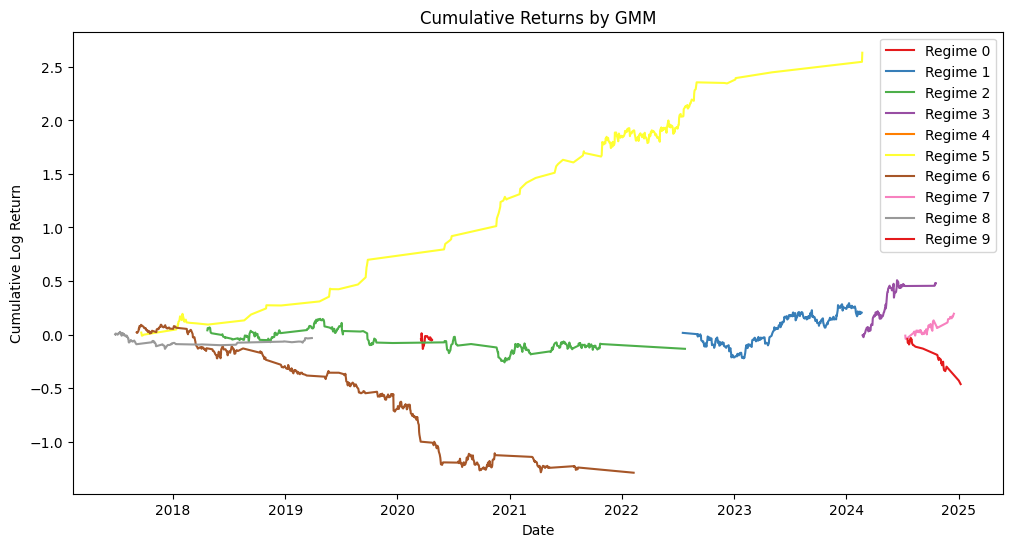

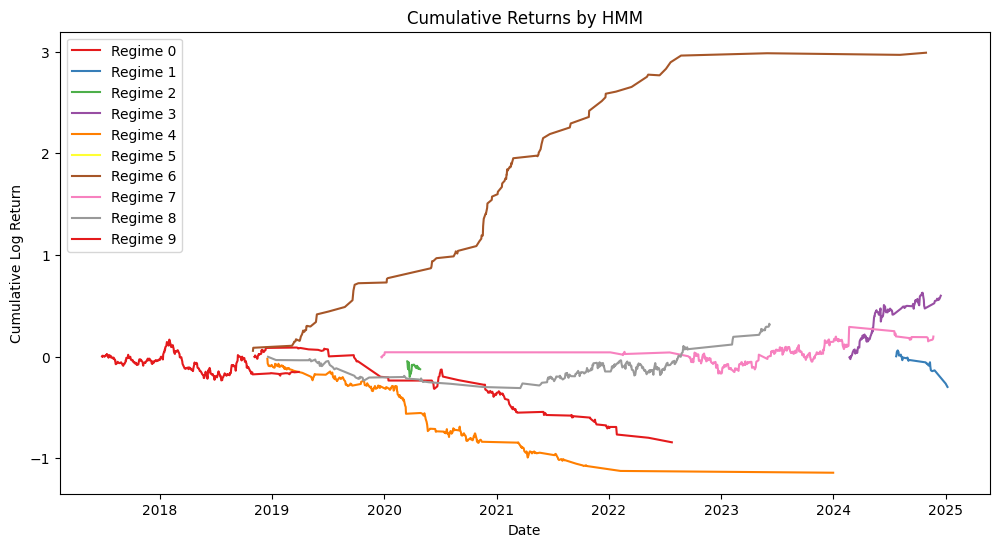

In [44]:
# === Visualization ===
def plot_regime_analysis(df, regime_col, title):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("Set1", n_colors=df[regime_col].nunique())
    
    for regime, color in zip(sorted(df[regime_col].unique()), colors):
        regime_data = df[df[regime_col] == regime]
        plt.plot(regime_data.index, regime_data['log_return'].cumsum(), label=f'Regime {regime}', color=color)
    
    plt.legend()
    plt.title(f'Cumulative Returns by {title}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Log Return')
    plt.show()

# Plot GMM Regimes
plot_regime_analysis(featured_df, 'gmm_regime', 'GMM')

# Plot HMM Regimes
plot_regime_analysis(featured_df, 'hmm_regime', 'HMM')


In [45]:
gmm_eval


{'Silhouette Score': 0.11371992927235827,
 'Davies-Bouldin Index': 1.886016250008782,
 'Kolmogorov-Smirnov': {'8-9': {'ks_stat': 0.4542124542124542,
   'p_value': 1.3557774265478321e-05},
  '6-8': {'ks_stat': 0.14368131868131867, 'p_value': 0.07344820892611288},
  '6-7': {'ks_stat': 0.2516297262059974, 'p_value': 0.0019113910824863352},
  '6-9': {'ks_stat': 0.32756410256410257, 'p_value': 0.0005826041249370075},
  '5-8': {'ks_stat': 0.3176823176823177, 'p_value': 1.1248505171552522e-06},
  '5-6': {'ks_stat': 0.22814685314685315, 'p_value': 6.539263986698906e-09},
  '5-7': {'ks_stat': 0.12451108213820078, 'p_value': 0.3964860242073452},
  '5-9': {'ks_stat': 0.331002331002331, 'p_value': 0.0007681810665423516},
  '2-8': {'ks_stat': 0.1278748573830541, 'p_value': 0.16618196807250915},
  '2-6': {'ks_stat': 0.07902480033627575, 'p_value': 0.12773596246264218},
  '2-5': {'ks_stat': 0.1933394474378081, 'p_value': 9.7596829712644e-06},
  '2-4': {'ks_stat': 0.6038251366120219, 'p_value': 0.7956

In [46]:
hmm_eval


{'Silhouette Score': 0.07226145217438161,
 'Davies-Bouldin Index': 2.0570828282585767,
 'Kolmogorov-Smirnov': {'6-9': {'ks_stat': 0.5392750442852233,
   'p_value': 8.814048189849033e-23},
  '6-8': {'ks_stat': 0.4447559179975082, 'p_value': 3.90205532901507e-15},
  '6-7': {'ks_stat': 0.49574598944185333, 'p_value': 2.6646018628072844e-19},
  '5-9': {'ks_stat': 0.5619596541786743, 'p_value': 0.8793103448275859},
  '5-6': {'ks_stat': 0.8807339449541285, 'p_value': 0.25454545454545463},
  '5-8': {'ks_stat': 0.6080246913580247, 'p_value': 0.7876923076923077},
  '5-7': {'ks_stat': 0.6508379888268156, 'p_value': 0.7019498607242337},
  '0-9': {'ks_stat': 0.10897641157007151, 'p_value': 0.13197771299777344},
  '0-6': {'ks_stat': 0.5799637558047344, 'p_value': 6.444315121529978e-21},
  '0-5': {'ks_stat': 0.5617283950617284, 'p_value': 0.8834355828220859},
  '0-4': {'ks_stat': 0.06172839506172839, 'p_value': 0.7693856045731875},
  '0-8': {'ks_stat': 0.17592592592592593, 'p_value': 0.0023530170147